# Importing the necessary packages

In [72]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, make_scorer

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


# Load the dataset

In [21]:
file_path = "/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(file_path)

In [22]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Check the columns info

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# Statistical Summary (Five Number Summary)

In [70]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.00,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80
Churn,7043.0,0.265370,0.441561,0.00,0.00,0.00,1.00,1.00


In [24]:
for cols in df.columns:
    print(cols, " : ", df[cols].unique())

customerID  :  ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender  :  ['Female' 'Male']
SeniorCitizen  :  [0 1]
Partner  :  ['Yes' 'No']
Dependents  :  ['No' 'Yes']
tenure  :  [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService  :  ['No' 'Yes']
MultipleLines  :  ['No phone service' 'No' 'Yes']
InternetService  :  ['DSL' 'Fiber optic' 'No']
OnlineSecurity  :  ['No' 'Yes' 'No internet service']
OnlineBackup  :  ['Yes' 'No' 'No internet service']
DeviceProtection  :  ['No' 'Yes' 'No internet service']
TechSupport  :  ['No' 'Yes' 'No internet service']
StreamingTV  :  ['No' 'Yes' 'No internet service']
StreamingMovies  :  ['No' 'Yes' 'No internet service']
Contract  :  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling  :  ['Yes' 'No']
PaymentMethod  :  ['Elect

In [25]:
df.replace(to_replace=["No_phone_service","No_internet_service"], value="No", inplace=True)

In [26]:
for cols in df.columns:
    print(cols, " : ", df[cols].unique())

customerID  :  ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender  :  ['Female' 'Male']
SeniorCitizen  :  [0 1]
Partner  :  ['Yes' 'No']
Dependents  :  ['No' 'Yes']
tenure  :  [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService  :  ['No' 'Yes']
MultipleLines  :  ['No phone service' 'No' 'Yes']
InternetService  :  ['DSL' 'Fiber optic' 'No']
OnlineSecurity  :  ['No' 'Yes' 'No internet service']
OnlineBackup  :  ['Yes' 'No' 'No internet service']
DeviceProtection  :  ['No' 'Yes' 'No internet service']
TechSupport  :  ['No' 'Yes' 'No internet service']
StreamingTV  :  ['No' 'Yes' 'No internet service']
StreamingMovies  :  ['No' 'Yes' 'No internet service']
Contract  :  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling  :  ['Yes' 'No']
PaymentMethod  :  ['Elect

In [27]:
len(df.loc[df["TotalCharges"]==" "])

11

In [28]:
df.loc[df["TotalCharges"]==" "]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [29]:
df.loc[(df["TotalCharges"]==" "), "TotalCharges"] = 0

In [30]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"])

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [32]:
df.replace(' ', '_', regex=True, inplace=True)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No_phone_service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No_phone_service,DSL,Yes,...,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber_optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,Yes


In [33]:
df["Churn"] = df["Churn"].replace(to_replace=["Yes", "No"], value=[1, 0])
df["Churn"].head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

# Box Plot of all the Variables
### To understand the distribution and outliers

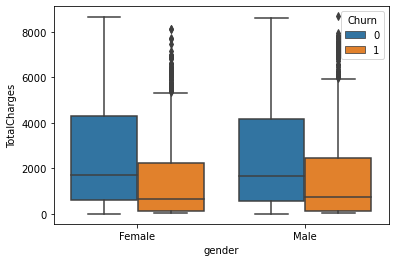

In [91]:
sns.boxplot(x=df["gender"], y=df["TotalCharges"], hue=df["Churn"]);

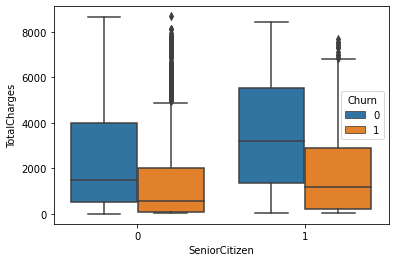

In [90]:
sns.boxplot(x=df["SeniorCitizen"], y=df["TotalCharges"], hue=df["Churn"]);

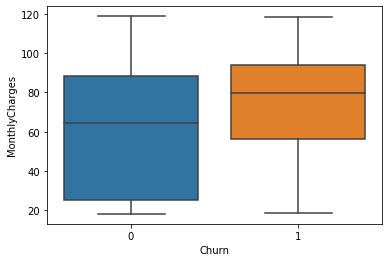

In [79]:
sns.boxplot(y=df["MonthlyCharges"], x=df["Churn"]);

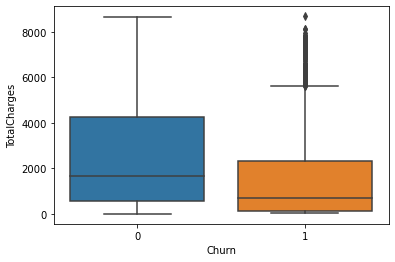

In [78]:
sns.boxplot(y=df["TotalCharges"], x=df["Churn"]);

# Pairplot of all the variables

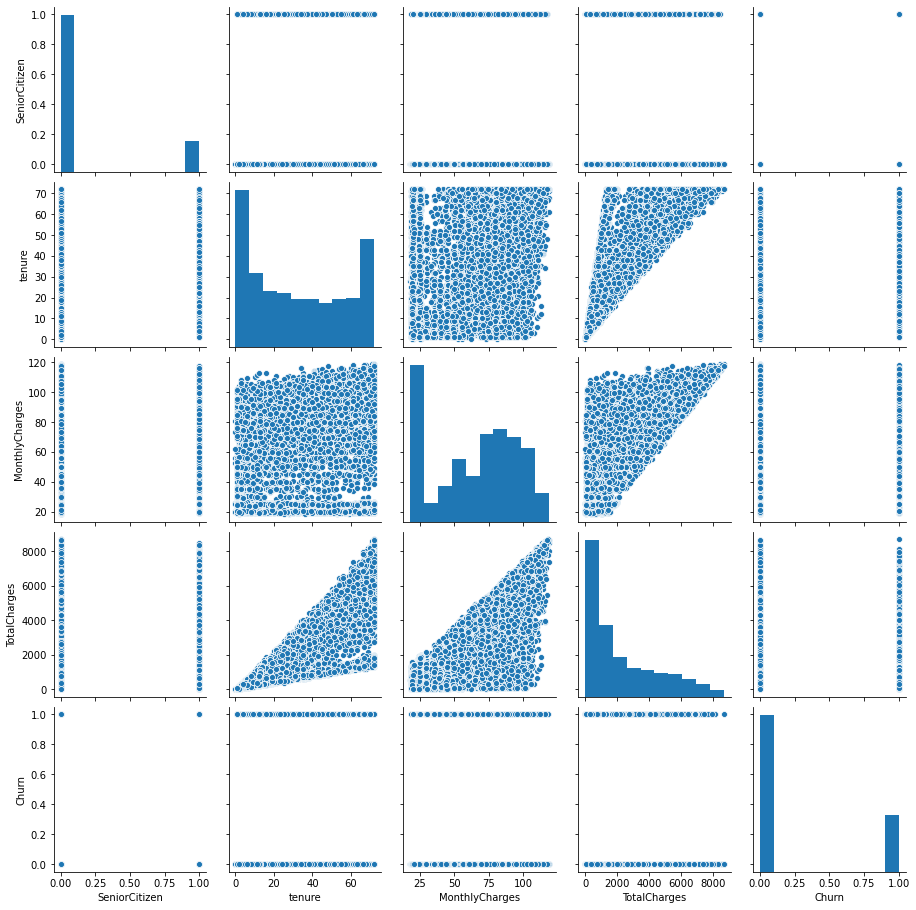

In [73]:
sns.pairplot(df);

# Separate the Independent and Dependent Variables

In [34]:
X = df.drop(columns="Churn", axis=1).copy()
X.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
3,7795-CFOCW,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65


In [36]:
y = df["Churn"].copy()
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

In [37]:
X.drop(columns="customerID", inplace=True)

In [38]:
cat_cols = list(X.columns[X.dtypes==object])
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

# One-Hot Encoding for the Categorical variables

In [39]:
X_encoded = pd.get_dummies(X, columns=cat_cols)

In [40]:
X_encoded.head(10)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,0,1,29.85,29.85,1,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,1,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,1,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
5,0,8,99.65,820.50,1,0,1,0,1,0,...,1,1,0,0,0,1,0,0,1,0
6,0,22,89.10,1949.40,0,1,1,0,0,1,...,0,1,0,0,0,1,0,1,0,0
7,0,10,29.75,301.90,1,0,1,0,1,0,...,0,1,0,0,1,0,0,0,0,1
8,0,28,104.80,3046.05,1,0,0,1,1,0,...,1,1,0,0,0,1,0,0,1,0
9,0,62,56.15,3487.95,0,1,1,0,0,1,...,0,0,1,0,1,0,1,0,0,0


In [41]:
y.unique()

array([0, 1])

### Checking the Class Imbalance 

In [42]:
sum(y)/len(y) * 100

26.536987079369588

In [43]:
display(X_encoded.shape, y.shape)

(7043, 45)

(7043,)

# Train Test Split with Stratification

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, test_size=0.3, random_state=24)

In [45]:
sum(y_train)/len(y_train) * 100

26.531440162271807

In [46]:
sum(y_test)/len(y_test) * 100

26.549929010885

# Building XGBoost Baseline Model

In [47]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic',
                           missing=None,
                           seed=24)

In [48]:
clf_xgb.fit(X_train,
           y_train,
           verbose=True,
           early_stopping_rounds=10,
           eval_metric='aucpr',
           eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.63012
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.65658
[2]	validation_0-aucpr:0.65150
[3]	validation_0-aucpr:0.65299
[4]	validation_0-aucpr:0.65302
[5]	validation_0-aucpr:0.64926
[6]	validation_0-aucpr:0.65990
[7]	validation_0-aucpr:0.66129
[8]	validation_0-aucpr:0.66328
[9]	validation_0-aucpr:0.66365
[10]	validation_0-aucpr:0.66514
[11]	validation_0-aucpr:0.66219
[12]	validation_0-aucpr:0.66274
[13]	validation_0-aucpr:0.66053
[14]	validation_0-aucpr:0.66043
[15]	validation_0-aucpr:0.65953
[16]	validation_0-aucpr:0.65551
[17]	validation_0-aucpr:0.65527
[18]	validation_0-aucpr:0.65580
[19]	validation_0-aucpr:0.65499
[20]	validation_0-aucpr:0.65499
Stopping. Best iteration:
[10]	validation_0-aucpr:0.66514



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=24,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=24,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

## Confusion Matrix

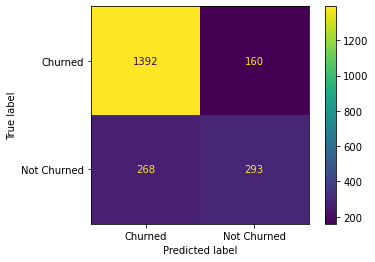

In [49]:
plot_confusion_matrix(clf_xgb,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=['Churned','Not Churned'])

## Tweaking the parameters for handling Class Imbalance in Dataset

`scale_pos_weight` is tuned for Imbalanced Datasets

In [50]:
param_grid = {
    'max_depth' : [3,4,5],
    'learning_rate' : [0,1,0.01,0.05],
    'gamma' : [0,0.25,1.0],
    'reg_lambda' : [0,1.0,10.0],
    'scale_pos_weight' : [1,3,5]
}

In [51]:
xgb_estimator = xgb.XGBClassifier(objective='binary:logistic',
                                  seed=24,
                                  subsample=0.9,
                                  colsample_bytree=0.5)

# Hyperparameter Tuning with GridSearchCV

In [52]:
clf_xgb_tuned = GridSearchCV(estimator=xgb_estimator,
                             param_grid=param_grid,
                             scoring='roc_auc',
                             verbose=2,
                             n_jobs=-1,
                             cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=24)
)

In [53]:
clf_xgb_tuned.fit(X_train,
                  y_train,
                  verbose=True,
                  early_stopping_rounds=10,
                  eval_metric='aucpr',
           eval_set=[(X_test, y_test)]
)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   51.8s


[0]	validation_0-aucpr:0.57645
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.60992
[2]	validation_0-aucpr:0.61450
[3]	validation_0-aucpr:0.61940
[4]	validation_0-aucpr:0.62966
[5]	validation_0-aucpr:0.63956
[6]	validation_0-aucpr:0.64086
[7]	validation_0-aucpr:0.64018
[8]	validation_0-aucpr:0.64261
[9]	validation_0-aucpr:0.64225
[10]	validation_0-aucpr:0.64198
[11]	validation_0-aucpr:0.64272
[12]	validation_0-aucpr:0.64077
[13]	validation_0-aucpr:0.64031
[14]	validation_0-aucpr:0.64065
[15]	validation_0-aucpr:0.64109
[16]	validation_0-aucpr:0.63992
[17]	validation_0-aucpr:0.64105
[18]	validation_0-aucpr:0.64074
[19]	validation_0-aucpr:0.64107
[20]	validation_0-aucpr:0.64063


[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:  1.3min finished


[21]	validation_0-aucpr:0.64038
Stopping. Best iteration:
[11]	validation_0-aucpr:0.64272



GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=24, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=24,
                                     subsample=0.9, tree_method=None,
                                

## GridSearchCV Results

In [55]:
clf_xgb_tuned.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=24,
              reg_alpha=0, reg_lambda=10.0, scale_pos_weight=3, seed=24,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [56]:
clf_xgb_tuned.best_params_

{'gamma': 0.25,
 'learning_rate': 0.05,
 'max_depth': 4,
 'reg_lambda': 10.0,
 'scale_pos_weight': 3}

In [57]:
clf_xgb_tuned.best_score_

0.844012372831596

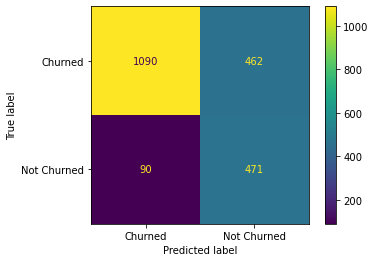

In [54]:
plot_confusion_matrix(clf_xgb_tuned,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=['Churned','Not Churned'])

In [66]:
y_pred = clf_xgb_tuned.predict(X_test)

## Classification Report for the Hyperparameter Tuned Model

In [67]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.70      0.92      0.80      1180
           1       0.84      0.50      0.63       933

    accuracy                           0.74      2113
   macro avg       0.77      0.71      0.71      2113
weighted avg       0.76      0.74      0.72      2113



# ROC AUC Curve for the Hyperparameter Tuned Model

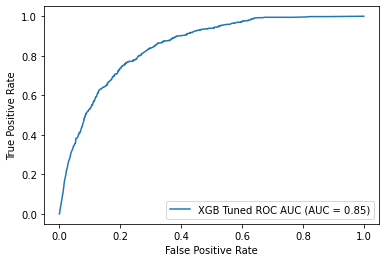

In [69]:
plot_roc_curve(clf_xgb_tuned,
               X_test,
               y_test,
               name='XGB Tuned ROC AUC');

# Precision-Recall Curve for the Hyperparameter Tuned Model

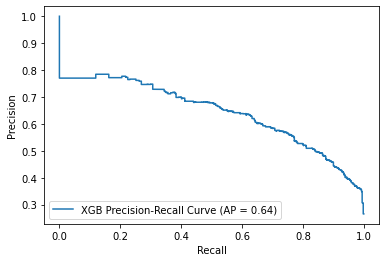

In [92]:
plot_precision_recall_curve(clf_xgb_tuned,
               X_test,
               y_test,
               name='XGB Precision-Recall Curve');

# Visualizing the XGBoost Tree

In [59]:
xgb_lone_estimator = xgb.XGBClassifier(
    objective='binary:logistic', 
    seed=24, 
    subsample=0.9, 
    colsample_bytree=0.5, 
    gamma = 0.25, 
    learning_rate=0.05, 
    max_depth=4,
    reg_lambda=10.0, 
    scale_pos_weight=3,
    n_estimator=1
)

In [60]:
xgb_lone_estimator.fit(X_train, y_train)

[16:59:09] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimator=1, n_estimators=100, n_jobs=0, num_parallel_tree=1,
              random_state=24, reg_alpha=0, reg_lambda=10.0, scale_pos_weight=3,
              seed=24, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [61]:
xgb_bst = xgb_lone_estimator.get_booster()

In [62]:
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s:  ' % importance_type, xgb_bst.get_score(importance_type=importance_type))

weight:   {'TechSupport_No': 29, 'tenure': 158, 'InternetService_Fiber_optic': 36, 'TotalCharges': 217, 'DeviceProtection_No': 16, 'InternetService_DSL': 23, 'Contract_One_year': 27, 'PhoneService_No': 20, 'PaperlessBilling_No': 42, 'OnlineSecurity_Yes': 18, 'SeniorCitizen': 47, 'Contract_Month-to-month': 38, 'PaymentMethod_Electronic_check': 51, 'StreamingTV_Yes': 23, 'MonthlyCharges': 240, 'StreamingMovies_Yes': 17, 'MultipleLines_No_phone_service': 6, 'OnlineSecurity_No': 34, 'Contract_Two_year': 28, 'PaymentMethod_Mailed_check': 17, 'PaymentMethod_Credit_card_(automatic)': 9, 'StreamingMovies_No': 14, 'PaperlessBilling_Yes': 16, 'gender_Female': 30, 'OnlineSecurity_No_internet_service': 1, 'PhoneService_Yes': 11, 'MultipleLines_No': 15, 'OnlineBackup_Yes': 20, 'Partner_No': 12, 'TechSupport_Yes': 27, 'InternetService_No': 13, 'Partner_Yes': 17, 'Dependents_No': 22, 'Dependents_Yes': 10, 'MultipleLines_Yes': 7, 'StreamingTV_No': 14, 'gender_Male': 6, 'OnlineBackup_No': 23, 'DevicePr

In [63]:
node_params = {
    'shape' : 'box',
    'style' : 'filled, rounded',
    'fillcolor' : '#78cbe'
}

leaf_params = {
    'shape' : 'box',
    'style' : 'filled',
    'fillcolor' : '#e48038'
}

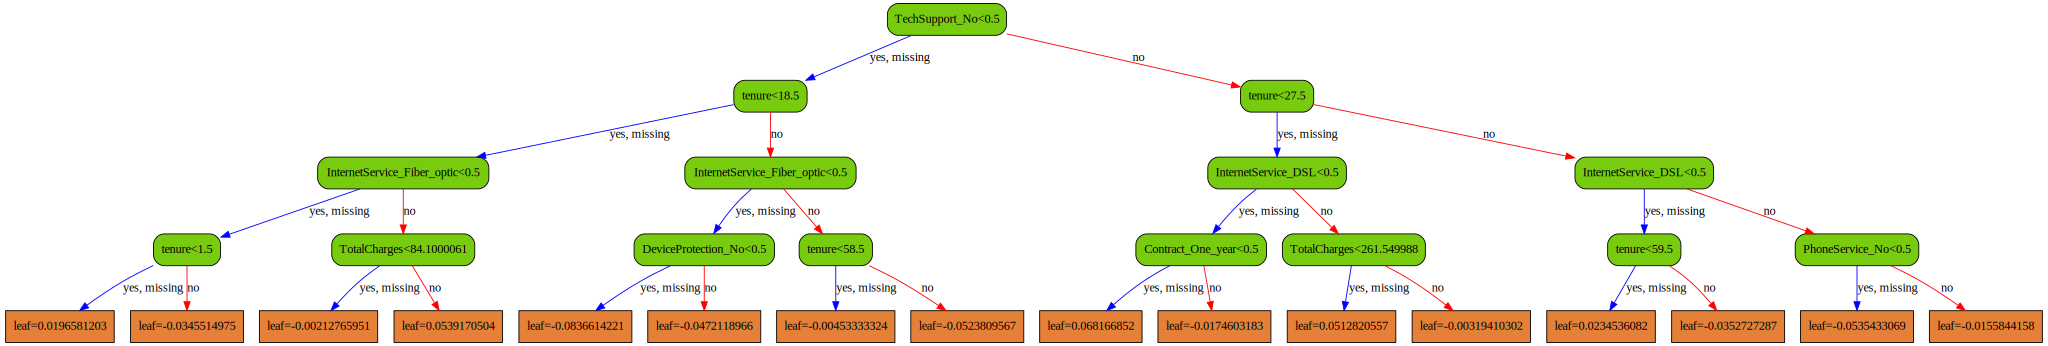

In [65]:
xgb.to_graphviz(xgb_lone_estimator,
                num_trees=0,
                size="5,5",
                condition_node_params=node_params,
                leaf_node_params=leaf_params
)